# Modelo de Kermack McKendrick

In [1]:
include("Taylor.jl")
using ADT
using PyPlot

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 2 methods)

Error absoluto

In [3]:
eps_abs = 1e-20

1.0e-20

In [4]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [5]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [6]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [7]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);

  1.097936 seconds (8.38 M allocations: 154.658 MB, 2.08% gc time)


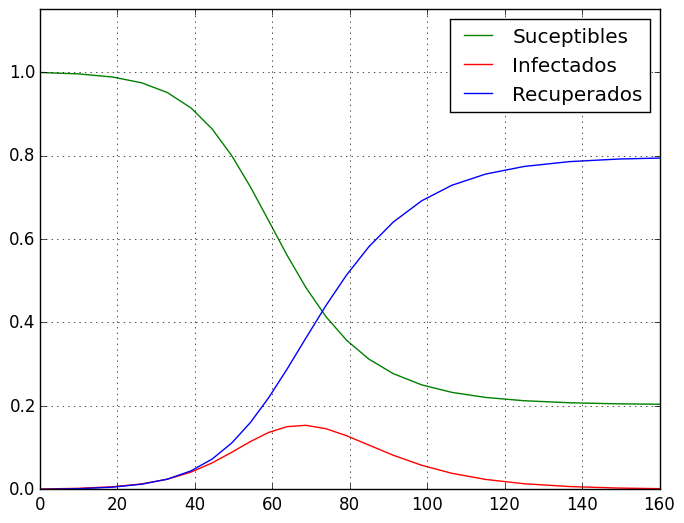

In [8]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Ahora hagamos un diagrama fase de esto, donde no esperamos ningún comportamiento peculiar.

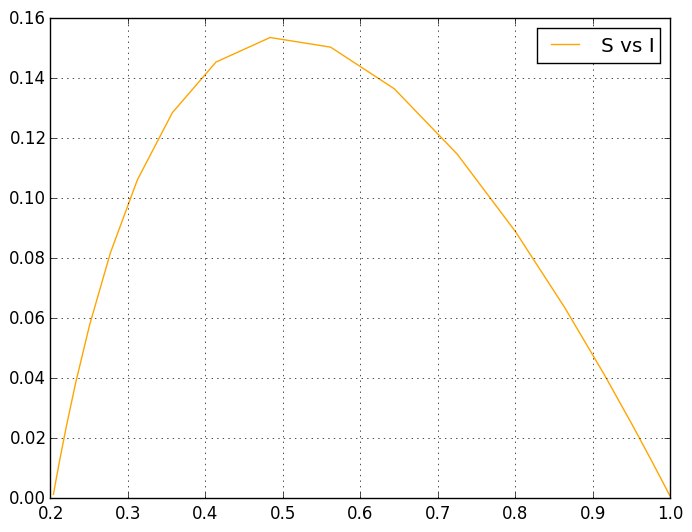

In [9]:
plot(s,i, color = "orange", label = "S vs I")
legend()
grid()
show()

Ahora introducimos un término de reincidencia $\phi$, quedando las ecuaciones como:

$$ \frac{dS}{dt} = -\beta SI + \phi R$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I -\phi R$$
Como sigue, definimos nuestras funciones de coeficientes y el integrador.

In [10]:
function coefs_1_re(gamma, beta, phi, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    F3(R) = phi*R
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) + F3(Tr)# F1 = -b*S*I + p*R
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) - F3(Tr) # F2 = g*I-p*R

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1_re (generic function with 2 methods)

In [11]:
function integrador_kermack_re(N, I0, R0, t0, tf, gamma, beta, phi)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    n_iteraciones = 1
    while t0 < tf && n_iteraciones < 500
        
        S,I,R = coefs_1_re(gamma, beta, phi, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
        n_iteraciones += 1
    end
    return t,s,i,r
end

integrador_kermack_re (generic function with 1 method)

Establecemos condiciones iniciales e integramos.

In [12]:
N = 1.
t_inicial = 0.
t_final = 1400.
beta = .5
gamma = .25
phi = 0.005
infectados_iniciales = N/1000
recuperados_iniciales = 0.

@time t,s,i,r = integrador_kermack_re(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta, phi);
length(t)

  1.371162 seconds (40.75 M allocations: 672.356 MB, 3.66% gc time)


115

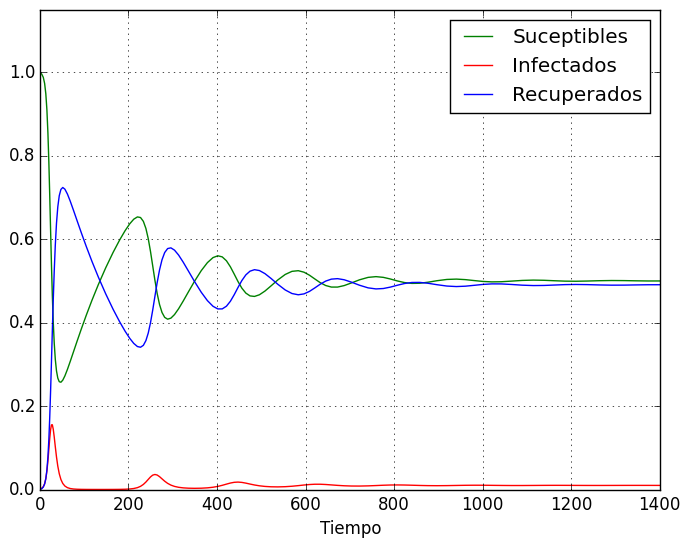

In [13]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,t_final,0,1.15])
grid()
legend()
xlabel("Tiempo")
show()

Dibujamos ahora el diagrama fase.

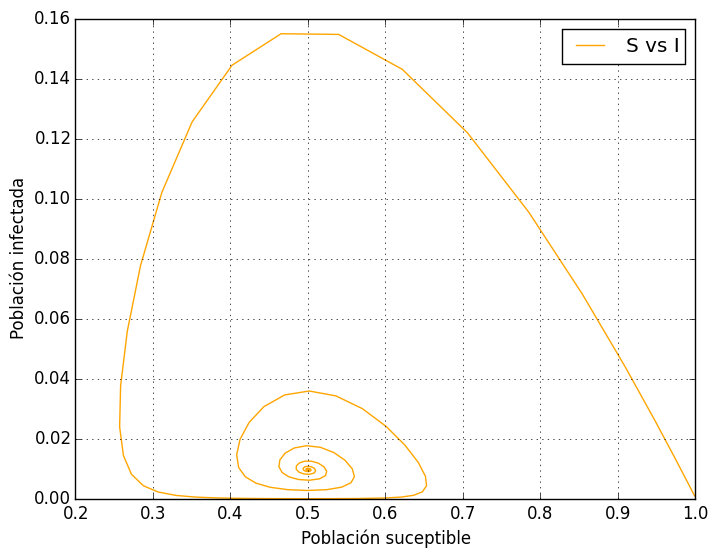

In [14]:
plot(s,i, color = "orange", label = "S vs I")
legend()
xlabel("Población suceptible")
ylabel("Población infectada")
grid()
show()

**Animación de la Solución**

Al inicial el programa debe ejecutar 2 veces la celda; la primera vez da error y la segunda muestra el video. El usar PyCall también interfiere con Pyplot asíque podría limpiarse el namespace para que no interfiriese con las celdas de abajo.

In [15]:
using PyCall
@pyimport matplotlib.animation as anim

In [17]:
tdata=t
xdata=s
ydata=i
#Use External Viewer for Animation
pygui(true)


#Construct Figure and Plot Data
fig = figure()
ax = axes(xlim = (minimum(xdata),maximum(xdata)),ylim=(minimum(ydata),maximum(ydata)))
global line1 = ax[:plot]([],[],"r-")[1]
global p1 = ax[:plot]([],[],"or")[1]

function init()
    global line1
    line1[:set_data]([],[])
    p1[:set_data]([],[])
    return (line1,p1)
end

step=min(1,length(tdata))
function animate(i)
    k = i + 1
    global line1    
    line1[:set_data](xdata[max(1,step*(k-50)):(step*k)],ydata[max(1,step*(k-50)):(step*k)])#grafica una linea con 50 ptos previos
    p1[:set_data]([xdata[step*k]],ydata[step*k])#grafica sólo el punto actual
    return (line1,p1)
end

#Call the animator.
myanim = anim.FuncAnimation(fig, animate, init_func=init, frames=ifloor(length(tdata)/step), interval=20)

#This will require ffmpeg or equivalent.
myanim[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

# Function for creating an embedded video given a filename
function html_video(filename)
    base64_video = base64(open(readbytes, filename))
    """<video controls src="data:video/x-m4v;base64,$base64_video">"""
end

display("text/html", html_video("test.mp4"))

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAbOhtZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjY5NCAzYjcwNjQ1IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlyaWdodCAyMDAzLTIwMTYgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAET5liIQAM//+9uy+BTX9n9CXESzF2kpwPiqkgIB3NMAAAAMAAAMAAAMAA0AdraId2gkE0AAAAwAL8AKKl/3We5nzAJffvNG2j0cDjHm63xYBOR7oMKk0zAiN/MHdBfynKeldzRQDP7NNVaIQMr1MqAnO4QVtJ7N5MRK6M5JtS+DjCwsUKEbkCaaU/Hfu62wm2v8AoN45LBevcBbKv7N8XboJhOjgGUSjbaD5bSDX91o+yurIUixdHEu6ia2ExF7W8vXMim7eu/ty4hpSr2NsS1CL9NmO335llHV588z6amCXw+0Y87Q3Oja+dwJJmDTiZMm53tOAYkXlHc5DhP8ZUrjukqevi/SzmGxMpvTEGHjh5fIvCRCnlJn0YgmbQ353/eeX1vDKNn2RHsCbRa+v02o+Enk1W8L635s3NSHKEDrq4YLLXJZp+rdJf2Wy6u5qB5vA5PS16pKtzqaWFtaHTfK/um4FFcOQ/o83TIgOsNOpd2HJNDfxkKqggc/coaUT8hlX0nqm41UcL+YQK17hKgpiTV3XKeOt275RjsiriABUf6bRQJJpnkmqtc/jzlvaMjhRY41S0PrRkdWuQQrAhI4OClvWVrpuyiHSyeiIaUrpuUw7SZzxb4oR/nNz/mA6TnYYpC7FS8dksEA/3811X8JU24BApULiQ0PgYIJVprX+Kuvebs7tO3IzlguiOxopeBfVpnKikKd5Je41ghXIEORrqGh+8EEWfNb++rCE3zhU1TuSIw3XZgAmOyL3r9CQnFsonB1NhrfIsmpOp5W1pzh8Zbfq1CNPCLq8Ak0qEyklhk0dwgu46yh27K0z9XPE5uEFGnFd0yIpVDD1P86ACZ8pNeK+RyGSk86zpIE/fyaLdQWKkar5IrD1JRnGAAADAeqqdzN1lputiy1keGxkBMAY4hWPpNfuMoaAAy0dZ4A8o57AA4Q8QBkMVwZvaXopJtEIt8xKve995HDQVzTpKXRjsxcenkHu49YSnM8tdzm3B+/P9Z6lozne+18uz/EpMeqIBsHp5Y5KIunMvFmCu9UBZu+1pkJ9AjSUjtNEDAuq8tdvsJumxizpezcZ5FDddyGbXiZWW8MlwTjmnfu2Rs6yMTZXLLlc7mCjXMOUABSMxqERAvmtQ0ylpMbCbhC/lS3JaKPBug+OIW19UiY9afJjH0fnUsZZcGBwtPC8gQUN3wgRy9vSuClci8l9nR+4KdhGB6QbUXrXGVJP/91UrtiNGoA5tJ59rbb1ujLN/C6/RAfh4myQOQnQCI/xKpZ3lAAA0/TuXLwxj6ystjZdXCUVolZmHn1ZwloAApIDiAGxMfGyO0ZB5X//JJMI0BVBVQpJkuvkEk4zHQjqWX4rhAb1dKAU/Glm/BF6e6FmX0ykbZbUU9jExcwAEoz2wHhbHn5OGYpv7gs22aN6ZKMRQuYgidStujoh1dXzRHLVxiyQQJg0Yx7mobTYlfTvLP+EA2iWg3seya1doRxn/oH8uAVk3lxYJ/Dyjryofgbk1rykfRE8Mx5Jn9ld/nsBakQr4k04YovEsfwiRzwHGQ6Gz85nVpjWY0Ko3JNVStvxwPE2EWLRq9m9t4NXg07sa57McsPeZ3CTAaNsRlAKVRbgRjud4NY7SoJfp3oHBAgvBStAyKG2tzsja8PcwG/gIAAAcE2B22LLwmTR5cnTWKiz6hs3D4BL6iOwAwgCggRgAoTVRPAWQlwZV116AHsR9GOAd/OFXBWN1GeCdKCrXktCnFF7v8CLICwfDk8g5T3CO8PnhrgNVCezO+EOTpwMBMqbs+I3IaCYD0R4H2wK7Ic4YS1TzSH7sBmXH4AAy5c6O38QeONg25zeTE6fWCKHiScOjtYt76kB8YbnnAS5aCdktXw5LY5MYkO38eLm/pfM1dKyNzg7RZjuW9WxyX8CZCp2fcOan85CNP4sPALyRgnioAHLD4wCda5/8/rAEECPPF/JK9N72JzmMIdtrvsuC39hUQ79HI6cbcH+CXYzf7XApZWcHrJIqddDQcQsI+LgUbtsprhlYaHzSDJGLYNh0/evSj8S2tkbdy519shXXQhPcCwMl7LqLiE5oHE9MHabplc8koTUMIG4JBKikare4I92MkhM3njMgmwnAdyCDwu2B7d0ij/o1dWAATcmn78XShrjGTlm2+1lA24tDqYdiGAggADkgjwBSvGazXpaA80UoL6ed5KsiQavwxo+sYYzQGA2GrgmY8T4t0JVPvqR2Y0/A0kROYRN53kZ/HxTnjbvw3kZhB72c64+vcgZwWS0xbqTXjcqZw/fAQDlKbwg5kcPjp6/eNQBffY8tJs+wO7bOPHrpDmEzKVxbDO3uZpuYBNNO6EpBTFe5947tcsNz+u1vklWT2fgAAI1JnnDNEDcq2xxwHHDWBltWN4NwicvkKwboF/JZW2F2eoKUWV4WKZJgBrjSVFWmJZFQ3jEXyAUkCR0gUqWfbb2Vt+bcOCJ75Aoxeh1OpfmNx1MYNWOaAVoZw/z5UxQLdPJz+yjjeYJzUO6HXVM71URDEWGLewqanRnxT/Xb///D6YveJ7EVQ+1FICTGZY8eDRf8sNYT4MZuEfVrWwlwB4bbLgsAAIX3JKxEsmrNSN0vvG+U9w8Uj/sIfjyCxYOoBLAO8ArZbk487UmXIttyIrXLAWgV4T0cbgPdDotVQyyj7Fp6qlpqc2LX1FM2+2n3j33gNnDUdPLqHvInW1wIQp8j7pzHSYITSwMGKHX7r7YEp2J0ejGCaoeCorF8HPnA5Dd+FPXVaMDEk09Ki5mHFJ5SnODceNr/eEkOVW8liVl7ZS0/UkUQZK0Jg+eAAdRenm4oNYnUqjNrQZqi8rdVYhAfKlhuZv3mJsKA3xEr7O0jZp8mgwmRNuLwX4DjAlWRj99iohlmH+3o1lKjrbPn0851igiKDC/XGoq2ST+Q9Pr19JVSvjx+FEnAl3Oyhn+KFtQ3qGIvwM3MlC


 in depwarn at deprecated.jl:73
 in base64 at deprecated.jl:30
 in html_video at In[17]:38
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at C:\Users\ARTURO\.julia\v0.4\IJulia\src\execute_request.jl:183
 in eventloop at C:\Users\ARTURO\.julia\v0.4\IJulia\src\IJulia.jl:143
 in anonymous at task.jl:447
while loading In[17], in expression starting on line 42


# Model SIRS con Nacimientos y Muertes

Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad. Además, consideraremos una tasa de reincidencia f de la población recuperada. De este modo, la población presenta el siguiente flujo:
$\mathcal{S} \rightarrow \mathcal{I} \rightarrow \mathcal{R} \rightarrow \mathcal{S}$, por lo que el modelo se denomina **SIRS** (donde además, consideramos los nacimientos y muertes). Entonces, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + f R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - f R \\
\end{array}

Ahora, realizaremos la integración de este sistema de ecuaciones. Sólo requeriremos modificar la función de coeficientes para considerar los términos adicionales y, además, modificar el integrador para que considere los parámetros adicionales.

In [15]:
function coefs_SIRS(γ,β,μ,f,S_0,I_0,R_0,n=50)
    N=S_0+I_0+R_0
    
    s=[S_0]
    i=[I_0]
    r=[R_0]  #inicializar arrays 
    
    F1(S,I,R) = -(β/N)*S*I + μ*(I+R)+f*R #N-S=I+R pues N=I+R+S 
    F2(S,I) = (β/N)*S*I -γ*I -μ*I
    F3(I,R) = γ*I-μ*R-f*R
    
    f1=Taylor(0) #inicializamos f's pues las variables definidas en el for son locales
    f2=Taylor(0)
    f3=Taylor(0)
    
    for k in 1:n
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)

        f1=F1(Ts,Ti,Tr)
        f2=F2(Ts,Ti)
        f3=F3(Ti,Tr)
        
        S_0 = f1.pol[k]/k
        I_0 = f2.pol[k]/k
        R_0 = f3.pol[k]/k
        
        push!(s,S_0)
        push!(r,R_0)
        push!(i,I_0)
           
    end
    
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    
    return s,i,r
end

coefs_SIRS (generic function with 2 methods)

In [16]:
"""
Esta función integra la ecuación diferencial del modelo de Kermack-McKendrick SIRS discurito previamente. Sus parámetros son:
integrador_kermack(N=población total,I0=infectados inicialmente,t0=tiempo inicial,tf=tiempo final,γ=tasa de recuperación,
β=tasa de infección,μ=tasa de natalidad,f=tasa,n=numero de términos en los pols. de Taylor). 
Se consideran nacimientos y muertes, pero se asume que la tasa de natalidad es igual que la de mortalidad. Con esto,
la población total se mantiene constante
"""
function integrador_kermack_SIRS(N, I0, R0, t0, tf, gamma, beta,mu,f,n=50)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_SIRS(gamma, beta,mu,f, S0, I0, R0,n)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    
    return t,s,i,r
end

integrador_kermack_SIRS (generic function with 2 methods)

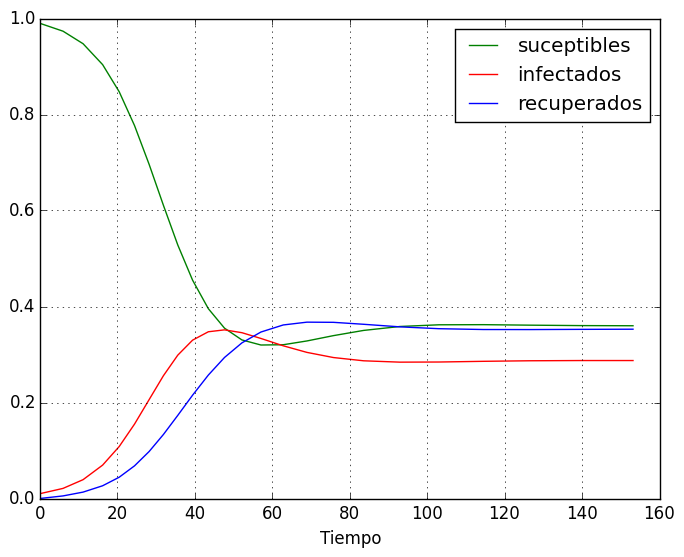

  0.853521 seconds (16.32 M allocations: 280.686 MB, 3.10% gc time)


In [17]:
N = 1.
I0 = N/100
R0 = 0.
S0 = N-I0-R0
ti = 0.
tf = 150.
beta = 0.2
gamma = 0.07
mu = 0.002
f = 0.055

@time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta ,mu,f);

using PyPlot

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
grid()
xlabel("Tiempo")
legend()
show()

  0.500849 seconds (13.86 M allocations: 229.868 MB, 3.16% gc time)
  0.497730 seconds (13.17 M allocations: 218.375 MB, 3.48% gc time)
  0.483970 seconds (13.17 M allocations: 218.375 MB, 3.07% gc time)
  0.469201 seconds (13.17 M allocations: 218.375 MB, 3.42% gc time)
  0.438803 seconds (13.17 M allocations: 218.375 MB, 3.67% gc time)


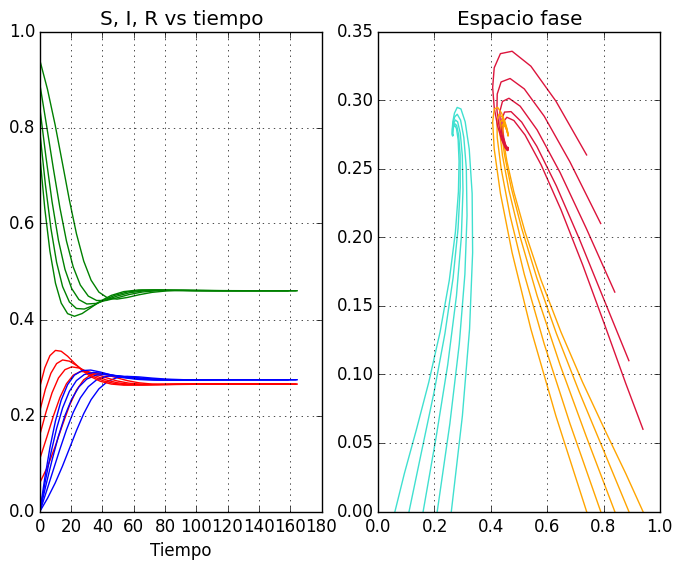

In [18]:
p = 5

for j in 1:p
    
    N = 1.
    I0 = N/100+0.05*j
    R0 = 0.
    S0 = N-I0-R0
    ti = 0.
    tf = 150.
    beta = 0.2
    gamma = 0.09
    mu = 0.002
    f = 0.085


    @time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta, mu, f);

    subplot(1,2,1)
    plot(t,s, color = "green", label = "Suceptibles")
    plot(t,i, color = "red", label = "Infectados")
    plot(t,r, color = "blue", label = "Recuperados")
    grid()
    title("S, I, R vs tiempo")
    xlabel("Tiempo")
    
    subplot(1,2,2)
    plot(s,i, color="crimson")
    plot(s,r,color="orange")
    plot(i,r,color="turquoise")
    grid()
    title("Espacio fase")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
end

# Para K especies (K=3)

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [19]:
eps_abs = 1e-50

1.0e-50

In [20]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fr = F2(gamma[i], Ti[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3 (generic function with 2 methods)

In [21]:
function k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3 (generic function with 1 method)

Integramos ahora con condiciones iniciales y en un intervalo de tiempo razonable.

In [22]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

In [23]:
beta = rand(3,3)/3
gamma = rand(3)/8
;

In [24]:
t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

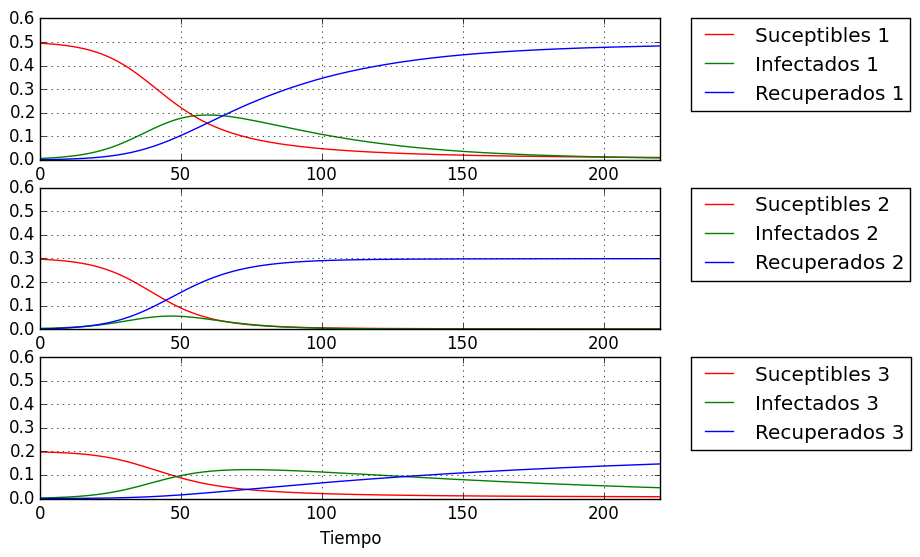

In [25]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axis([0, 220, 0, 0.6])
    grid()
end
xlabel("Tiempo")
show()

In [26]:
suma = 0
for k = 1:3
    suma += s3[k]+i3[k]+r3[k]
end
dump(suma)

Array(Float64,(140,)) [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]


Como vemos, la población total $N$ se mantiene constante.

Ahora que nuestro integrador funciona, complicamos las cosas e implementaremos un factor de reincidencia $\phi$ para cada una de las especies.

$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3 + \phi_i R_i$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i - \phi_i R_i$$

Modificamos un poco nuestro código anterior para lograrlo. Definimos una función para calcular los coeficientes y nuestro integrador.

In [27]:
function coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    F3(phi_i,R) = phi_i*R
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fs += F3(phi[i],Tr[i])
            fr = F2(gamma[i], Ti[i])-F3(phi[i],Tr[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3_reincidencia (generic function with 2 methods)

In [28]:
function k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta, phi)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    n_iteracion = 1
    
    while t0 < tf && n_iteracion < 2000
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
        n_iteracion += 1
    end
    return t,s,i,r
end

k_3_reincidencia (generic function with 1 method)

Definimos nuestras matrices de coeficientes. $\beta_{ij}$ es la matriz de coeficientes de transmisión, $\gamma_i$ la de coeficientes de recuperación (con $1/\gamma_i$ el tiempo promedio de recuperación) y $\phi_i$ la matriz de reincidencia o re-contagio. Al no tener datos experimentales, tomamos valores que están de acuerdo con la teoría.

In [29]:
# Hacemos 3 matrices de prueba con valores pre-establecidos.

phi1 = ([0.011980782470983145,0.0122242866833574,0.12049916741165438])
gamma1 = ([0.0920466,0.0690204,0.0427661])
beta1 = [0.138933 0.0147811 0.0747647; 0.0243735 0.116977 0.0574383; 0.183494 0.109088 0.283322]
;

In [30]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/11
phi = rand(3)/80
;

Definimos ahora valores iniciales y el intervalo de tiempo para que nuestro integrador pueda operar.

In [31]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 700.
;

In [32]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, 
beta1, phi);
length(t3)

 15.354122 seconds (414.25 M allocations: 6.708 GB, 3.34% gc time)


275

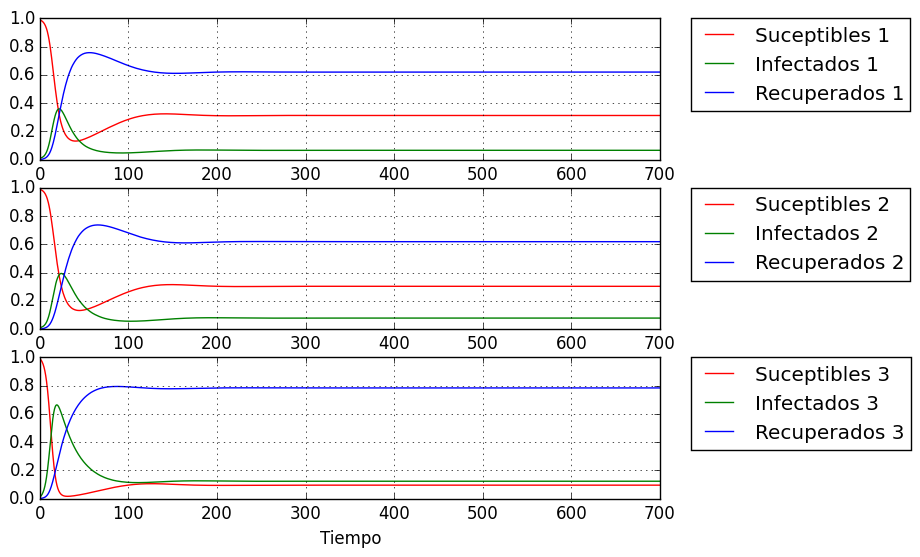

In [33]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

Muchos diagramas de fase a lo tonto.

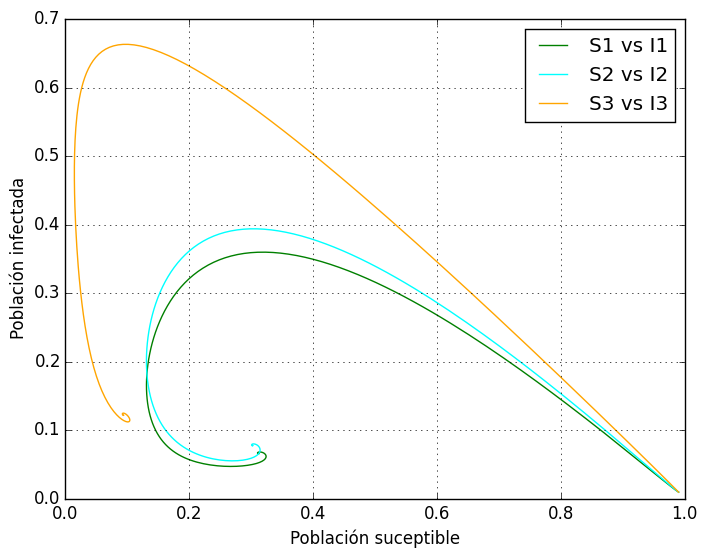

In [34]:
plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
# plot(s3[1],i3[2], color = "red", label = "S1 vs I2")
# plot(s3[1],i3[3], color = "blue", label = "S1 vs I3")
plot(s3[2],i3[2], color = "cyan", label = "S2 vs I2")
# plot(s3[2],i3[3], color = "magenta", label = "S2 vs I3")
plot(s3[3],i3[3], color = "orange", label = "S3 vs I3")
# plot(r3[1],i3[1], color = "peru", label = "R3 vs I3")
legend()
grid()
xlabel("Población suceptible")
ylabel("Población infectada")
show()

Ahora busquemos alguna bifurcación variando I0_1. Declaramos de nuevo nuestros parámetros.

In [35]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

 10.391420 seconds (308.17 M allocations: 4.982 GB, 3.42% gc time)
 10.326122 seconds (306.66 M allocations: 4.957 GB, 3.36% gc time)
 10.272801 seconds (306.66 M allocations: 4.957 GB, 3.39% gc time)
 10.129571 seconds (305.15 M allocations: 4.933 GB, 3.38% gc time)
  9.921195 seconds (300.62 M allocations: 4.859 GB, 3.44% gc time)
  9.933338 seconds (300.62 M allocations: 4.859 GB, 3.45% gc time)
  9.849570 seconds (297.60 M allocations: 4.811 GB, 3.50% gc time)
 10.025149 seconds (296.09 M allocations: 4.786 GB, 3.41% gc time)
  9.759540 seconds (293.07 M allocations: 4.737 GB, 3.44% gc time)
  9.662946 seconds (291.56 M allocations: 4.713 GB, 3.46% gc time)
  9.572757 seconds (290.05 M allocations: 4.688 GB, 3.44% gc time)
  9.479821 seconds (287.03 M allocations: 4.640 GB, 3.50% gc time)
  9.454757 seconds (285.51 M allocations: 4.615 GB, 3.48% gc time)
  9.550447 seconds (284.00 M allocations: 4.591 GB, 3.51% gc time)
  9.408859 seconds (282.49 M allocations: 4.566 GB, 3.48% gc t

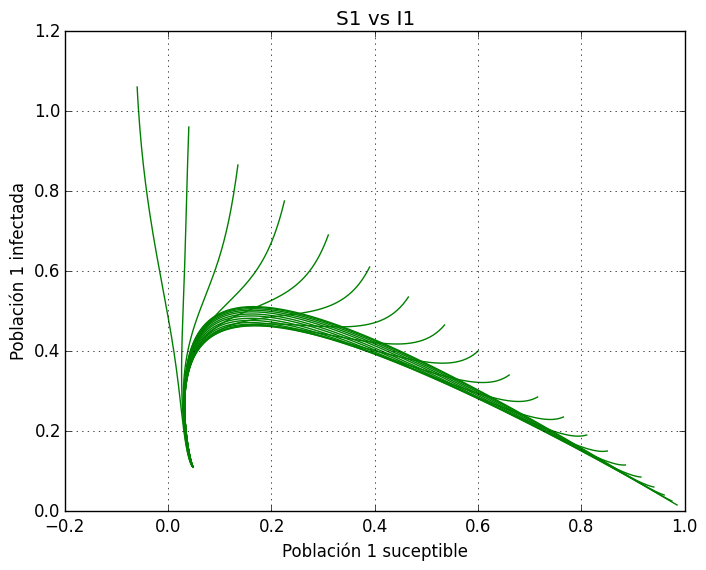

  9.050853 seconds (273.43 M allocations: 4.420 GB, 3.53% gc time)


In [36]:
for i in 1:20
    I0_1 += 0.005*i
    @time t3, s3, i3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, 
    gamma1, beta, phi1);    
    plot(s3[1],i3[1], color = "green")
end
grid()
title("S1 vs I1")
xlabel("Población 1 suceptible")
ylabel("Población 1 infectada")
show()

Lo de abajo es un ejercicio de metaprogramming, no lo borren pls

In [37]:
for k = 1:3
    
    hola = symbol(string("hola",k))
    @eval ($hola) = ($k)
end

In [38]:
using NLsolve

LoadError: LoadError: ArgumentError: NLsolve not found in path
while loading In[38], in expression starting on line 1

In [281]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/10
phi = rand(3)/450
;

$x[1,2,3,4,5,6,7,8,9] = (S1,S2,S3,I1,I2,I3,R1,R2,R3) $

In [39]:
function soluciones!(x, svec)
    svec[1] = 0
    svec[2] = 0
    svec[3] = 0
    ### Para S1, S2, S3
    for j = 1:3
        for k = 1:3
            svec[j] += -beta[j,k]*x[j]*x[k+3]
        end
    svec[j] += phi[j]*x[j+6]
    end
    ### Para R1, R2, R3
    for j = 1:3
        svec[j+6] = gamma[j]*x[j+3]-phi[j]*x[j+6]
    end
    ### Para I1, I2, I3
    svec[4] = N1-x[1]-x[4]-x[7]
    svec[5] = N2-x[2]-x[5]-x[8]
    svec[6] = N3-x[3]-x[6]-x[9]
end

soluciones! (generic function with 1 method)

In [40]:
x_inicial = 0.3*ones(9)
resultados = nlsolve(soluciones!,x_inicial)

LoadError: LoadError: UndefVarError: nlsolve not defined
while loading In[40], in expression starting on line 2

In [41]:
S_estable_1 = resultados.zero[1]
S_estable_2 = resultados.zero[2]
S_estable_3 = resultados.zero[3]
I_estable_1 = resultados.zero[4]
I_estable_2 = resultados.zero[5]
I_estable_3 = resultados.zero[6]
R_estable_1 = resultados.zero[7]
R_estable_2 = resultados.zero[8]
R_estable_3 = resultados.zero[9]
tiempo_inicial = 0.
tiempo_final = 2500.
;

LoadError: LoadError: UndefVarError: resultados not defined
while loading In[41], in expression starting on line 1

In [42]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_estable_1, I_estable_2, 
I_estable_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
gamma, beta, phi);

LoadError: LoadError: UndefVarError: I_estable_1 not defined
while loading In[42], in expression starting on line 155

In [43]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError(u'x and y must have same first dimension',)
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\pyplot.py", line 3099, in plot
    ret = ax.plot(*args, **kwargs)
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py", line 1373, in plot
    for line in self._get_lines(*args, **kwargs):
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_base.py", line 304, in _grab_next_args
    for seg in self._plot_args(remaining, kwargs):
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_base.py", line 282, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_base.py", line 223, in _xy_from_xy
    raise ValueError("x and y must have same first dimension")

while loading In[43], in expression starting on line 1

In [44]:
su = hcat([s3[k] for k in 1:3]...)

147x3 Array{Float64,2}:
 0.123888  -0.0309972   0.000425197
 0.122322  -0.0280726   0.00247921 
 0.12086   -0.0253037   0.0045284  
 0.119501  -0.0226836   0.00657406 
 0.118245  -0.0202052   0.00861741 
 0.11709   -0.0178619   0.0106595  
 0.116036  -0.015647    0.0127014  
 0.115081  -0.0135541   0.014744   
 0.114225  -0.0115769   0.016788   
 0.113466  -0.00970928  0.0188342  
 0.112805  -0.00794525  0.0208832  
 0.112238  -0.00627906  0.0229355  
 0.111767  -0.00470513  0.0249915  
 ⋮                                 
 0.133889   0.0190034   0.100426   
 0.13389    0.0190034   0.100426   
 0.133891   0.0190034   0.100427   
 0.133891   0.0190034   0.100427   
 0.133891   0.0190033   0.100427   
 0.133891   0.0190032   0.100427   
 0.13389    0.0190031   0.100427   
 0.13389    0.019003    0.100426   
 0.133889   0.0190029   0.100426   
 0.133889   0.0190029   0.100426   
 0.133889   0.0190028   0.100426   
 0.133888   0.0190027   0.100425   

In [108]:
a = [1 1 1; 2 2 2;3 3 3]
b = [4 4 4]
c = vcat(a)

3x3 Array{Int64,2}:
 1  1  1
 2  2  2
 3  3  3

In [285]:
I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3
tiempo_inicial = 0.
tiempo_final = 500.

for i in 0:4
    I_perturbado_1 += 0.005*i
    I_perturbado_2 += 0.005*i
    I_perturbado_3 += 0.005*i
    
    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma, beta, phi);  
    
    colores = ["darkorchid", "coral", "gold"]
    
    for k in 1:3
#     k = 1
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

LoadError: LoadError: UndefVarError: I_estable_1 not defined
while loading In[44], in expression starting on line 1

Parámetros beta, gamma y phi bonitos.

In [298]:
Beta = [0.134526   0.0449375  0.283664; 0.0322725  0.319525   0.253701; 0.282935   0.239162   0.113143]
Gamma = [0.0465392; 0.0549394; 0.0497149]
Phi = [0.00212581; 0.00188398; 0.00152644]
;

In [45]:
I_crit_1 = I_perturbado_1
I_crit_2 = I_perturbado_2
I_crit_3 = I_perturbado_3
;

LoadError: LoadError: UndefVarError: I_perturbado_1 not defined
while loading In[45], in expression starting on line 1

In [46]:
I_perturbado_1 = I_crit_1
I_perturbado_2 = I_crit_2
I_perturbado_3 = I_crit_3

for i in 1:4
    I_perturbado_1 += 0.001*i
    I_perturbado_2 += 0.005*i
    I_perturbado_3 += 0.01*i

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma, beta, phi);  

    colores = ["darkorchid", "coral", "gold"]
    for k = 1:1
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

LoadError: LoadError: UndefVarError: I_crit_1 not defined
while loading In[46], in expression starting on line 1

In [47]:
for i in 1:7
    I_perturbado_1 += 0.001*i
    I_perturbado_2 += 0.005*i
    I_perturbado_3 += 0.01*i

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma, beta, phi);  

    colores = ["darkorchid", "coral", "gold"]
    plot(s3[1],i3[1], color = colores[1])
end
grid()
show()

LoadError: LoadError: UndefVarError: I_perturbado_1 not defined
while loading In[47], in expression starting on line 1

ESTO SE DESCONTROLÓ

Los parámetros de abajo son para las curvas de arriba, las delgaditas

In [296]:
gamma_1 = [0.0382117; 0.0378735; 0.0425732]
phi_1 = [0.00614901; 0.00135588; 0.00385677]
beta_1 = [0.159791  0.143463  0.136713; 0.330302  0.152469  0.304485; 0.160856  0.30528   0.0269721]
;